In [209]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob as blob

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS

# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

%matplotlib inline

### 1. Import data and convert to df

In [91]:
with open('tweets/donald_tweets.pkl', 'r') as picklefile:
    dt_data = pickle.load(picklefile)

with open('tweets/hillary_tweets.pkl', 'r') as picklefile:
    hc_data = pickle.load(picklefile)
    
with open('tweets/bernie_tweets.pkl', 'r') as picklefile:
    bs_data = pickle.load(picklefile)
    
with open('tweets/cruz_tweets.pkl', 'r') as picklefile:
    tc_data = pickle.load(picklefile)

with open('tweets/rubio_tweets.pkl', 'r') as picklefile:
    mr_data = pickle.load(picklefile)

In [95]:
def data_to_df(data, name):
    """Convert list object of tweet data into dataframe; keep only important columns."""
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count', 
            'coordinates', 'place', 
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 
            'entities']
    df = df[keep]
    df['candidate'] = name
    return df

# rm = ['extended_entities', 'contributors', 'favorited', 'id_str', 'lang', 'geo', 
#       'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 
#       'source', 'retweeted', 'retweeted_status', 'truncated', 'user', 'possibly_sensitive', 
#       'quoted_status_id_str']

In [96]:
dt = data_to_df(dt_data, 'trump')
hc = data_to_df(hc_data, 'clinton')
bs = data_to_df(bs_data, 'sanders')
tc = data_to_df(tc_data, 'cruz')
mr = data_to_df(mr_data, 'rubio')

In [143]:
tweets = pd.concat([dt, hc, bs, tc, mr], ignore_index = True)

### 2. Exploratory data analysis - candidate metadata

In [ ]:
by_cand = tweets.groupby('candidate')

In [138]:
favs = by_cand[['favorite_count', 'retweet_count']].mean()
print favs

           favorite_count  retweet_count
candidate                               
clinton       1239.042144     770.490548
cruz           254.283442     327.395073
rubio          251.075843     188.861111
sanders       1978.685039    1249.021417
trump         4265.950510    1777.918961


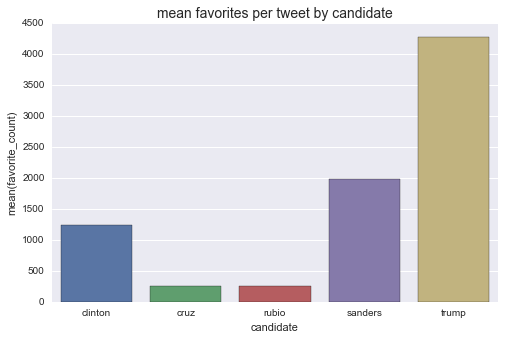

In [137]:
plt.figure(figsize = (8, 5))
sns.barplot(favs.index, 'favorite_count', data = favs)
plt.title('mean favorites per tweet by candidate', fontsize = 14)
plt.show()

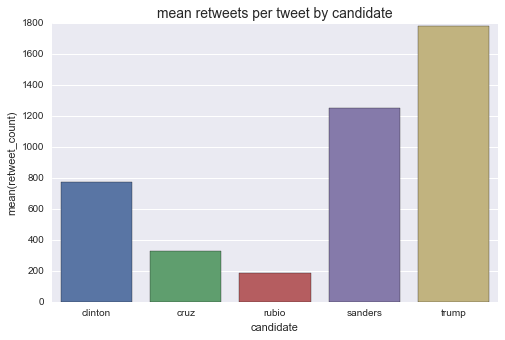

In [135]:
plt.figure(figsize = (8, 5))
sns.barplot(favs.index, 'retweet_count', data = favs)
plt.title('mean retweets per tweet by candidate', fontsize = 14)
plt.show()

### 3. Add nlp features

Add sentiment, modality, and mood scores.

In [144]:
# pattern/textblob sentiment reference: http://www.clips.ua.ac.be/pages/pattern-en#sentiment
"""
modality > 0.5 = fact
mood = indicative (fact, belief), imperative (command, warning), conditional (conjecture), subjunctive (wish, opinion)
sentiments = (polarity, subjectivity)
"""


Define functions to tokenize.

In [224]:
def get_clean_tokens(text):  
    """Return tokens for each review; exclude stop words and lemmatize."""
    # letters_only = re.sub("[^a-zA-Z]", " ", text) 
    words = ' '.join(text.lower().split())
    #words = ' '.join(split_text.lower().split())
    tokens = [token.lemma_ for token in nlp(words)]
    filtered = [t for t in tokens if t not in stop and t != '' and t != ' ' and t != '\n' and t != '\n\n']
    return ' '.join(filtered)

In [195]:
def get_features(df):
    # add sentiment, modality, and mood scores 
    df['sentiment'] = df.text.apply(lambda x: sentiment(x)[0])
    df['mood'] = df.text.apply(mood)
    df['modality'] = df.text.apply(modality)
    
    return df

In [207]:
nlp = English()

In [213]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [214]:
stop = STOPWORDS
punct = {p for p in string.punctuation if p != '@' and p != '#'}

In [205]:
single = tweets.loc[1, 'text']

In [225]:
print single
print get_clean_tokens(single)

In all of television- the only one who said anything bad about last nights landslide victory-- was dopey @KarlRove. He should be fired!
television- bad night landslide victory-- dopey @karlrove . !


In [196]:
test = tweets.loc[:10, :]

In [198]:
test2.head()

,id,created_at,text,favorite_count,retweet_count,coordinates,place,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,entities,candidate,sentiment,mood,modality
0,702561529447763968,Wed Feb 24 18:31:36 +0000 2016,MAKE AMERICA GREAT AGAIN! https://t.co/IVSR0hmh5g,4493,1917,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...",trump,1.000000,imperative,1.00
1,702560558269202433,Wed Feb 24 18:27:44 +0000 2016,In all of television- the only one who said an...,3695,1127,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices...",trump,-0.233333,conditional,0.45
2,702542084776001537,Wed Feb 24 17:14:20 +0000 2016,I am in Virginia @RegentU Presidential forum w...,3054,921,None,"{u'country_code': u'US', u'url': u'https://api...",False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices...",trump,0.000000,indicative,0.75
3,702539414224936960,Wed Feb 24 17:03:43 +0000 2016,I am self funding my campaign &amp; don't owe ...,6579,2259,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...",trump,0.000000,indicative,0.55
4,702526610646429696,Wed Feb 24 16:12:50 +0000 2016,.@USATODAY Poll and @QuinnipiacPoll say that I...,6177,2341,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices...",trump,0.000000,imperative,0.25


In [178]:
print modality(test)
print mood(test)
print sentiment(test)
print wordnet.synsets('sad', ADJECTIVE)[0].weight # for single words only 

0.75
indicative
(0.0, 0.0)
(-0.625, 0.875)


In [140]:
tweets.head()

,id,created_at,text,favorite_count,retweet_count,coordinates,place,is_quote_status,quoted_status,quoted_status_id,in_reply_to_screen_name,in_reply_to_status_id,entities,candidate
0,702561529447763968,Wed Feb 24 18:31:36 +0000 2016,MAKE AMERICA GREAT AGAIN! https://t.co/IVSR0hmh5g,4493,1917,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...",trump
1,702560558269202433,Wed Feb 24 18:27:44 +0000 2016,In all of television- the only one who said an...,3695,1127,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices...",trump
2,702542084776001537,Wed Feb 24 17:14:20 +0000 2016,I am in Virginia @RegentU Presidential forum w...,3054,921,None,"{u'country_code': u'US', u'url': u'https://api...",False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices...",trump
3,702539414224936960,Wed Feb 24 17:03:43 +0000 2016,I am self funding my campaign &amp; don't owe ...,6579,2259,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [], u'hasht...",trump
4,702526610646429696,Wed Feb 24 16:12:50 +0000 2016,.@USATODAY Poll and @QuinnipiacPoll say that I...,6177,2341,None,None,False,NaN,NaN,None,NaN,"{u'symbols': [], u'user_mentions': [{u'indices...",trump
